In [39]:
import numpy as np
import pandas as pd
from operator import attrgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/files_mate
df = pd.read_csv("Data_Analyst_Test_Task_Data.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/files_mate


,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id
0,0001feb9-ec8e-4f53-83c8-a829bbbe1838,18.05.2023 22:16:16,trial,weekly.2.49,False,7,0,0,e99b4003-7bb9-4cbe-a585-e8a103b0e3cb,NaN
1,0001feb9-ec8e-4f53-83c8-a829bbbe1838,18.05.2023 22:25:56,cancellation,weekly.2.49,False,7,0,0,dc4e828a-f365-46e4-90ef-bb2785379d1a,NaN
2,00026e14-e302-4772-b691-8b0e67ab0c32,30.05.2023 07:10:37,trial,weekly.2.49,False,7,0,0,b585adc7-f22a-4cd4-b863-2eb256d697b4,NaN
3,00026e14-e302-4772-b691-8b0e67ab0c32,05.06.2023 23:10:44,purchase,weekly.2.49,False,7,0,"2,49",b672df8a-fcb2-4737-8a5f-98a85b183609,NaN
4,00026e14-e302-4772-b691-8b0e67ab0c32,12.06.2023 23:10:57,purchase,weekly.2.49,False,7,0,"2,49",33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36005 entries, 0 to 36004
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   uuid                     36005 non-null  object
 1   event_timestamp          36005 non-null  object
 2   event_name               36005 non-null  object
 3   product_id               36005 non-null  object
 4   is_trial                 36005 non-null  bool  
 5   period                   36005 non-null  int64 
 6   trial_period             36005 non-null  int64 
 7   revenue_usd              36005 non-null  object
 8   transaction_id           36005 non-null  object
 9   refunded_transaction_id  202 non-null    object
dtypes: bool(1), int64(2), object(7)
memory usage: 2.5+ MB


In [41]:
df["revenue_usd"] = df["revenue_usd"].str.replace(",", ".").astype(float)
df["event_timestamp"] = pd.to_datetime(df["event_timestamp"], format="%d.%m.%Y %H:%M:%S")

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36005 entries, 0 to 36004
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   uuid                     36005 non-null  object        
 1   event_timestamp          36005 non-null  datetime64[ns]
 2   event_name               36005 non-null  object        
 3   product_id               36005 non-null  object        
 4   is_trial                 36005 non-null  bool          
 5   period                   36005 non-null  int64         
 6   trial_period             36005 non-null  int64         
 7   revenue_usd              36005 non-null  float64       
 8   transaction_id           36005 non-null  object        
 9   refunded_transaction_id  202 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 2.5+ MB


In [43]:
df["event_month"] = df["event_timestamp"].dt.to_period('M')
df['cohort'] = df.groupby("uuid")["event_timestamp"].transform('min').dt.to_period('M')
df_cohort = df.groupby(["cohort", "event_month"]).agg(n_customers=('uuid', 'nunique'), revenue=('revenue_usd', 'sum')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.event_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort['arpu'] = df_cohort['revenue'] / df_cohort['n_customers']
df_cohort['cum_revenue'] = df_cohort.groupby('cohort')['revenue'].cumsum()
df_cohort['cum_arpu'] = df_cohort.groupby('cohort')['arpu'].cumsum()
df_cohort.head()

,cohort,event_month,n_customers,revenue,period_number,arpu,cum_revenue,cum_arpu
0,2023-03,2023-03,3405,5374.00897,0,1.578270,5374.00897,1.578270
1,2023-03,2023-04,481,6329.69930,1,13.159458,11703.70827,14.737728
2,2023-03,2023-05,308,5815.64988,2,18.881980,17519.35815,33.619708
3,2023-03,2023-06,219,4112.32958,3,18.777761,21631.68773,52.397469
4,2023-03,2023-07,172,3207.83692,4,18.650215,24839.52465,71.047683


In [44]:
customer_lifetime = (
    df.groupby("uuid")
      .apply(lambda x: (x["event_month"].max() - x["event_month"].min()).n + 1)
      .mean()
)
total_arpu = df['revenue_usd'].sum() / df['uuid'].nunique()
LTV = total_arpu * customer_lifetime
print(f"Середній ARPU = {total_arpu:.2f} USD")
print(f"Середній Customer Lifetime = {customer_lifetime:.2f} місяців")
print(f"Фактичний LTV = {LTV:.2f} USD")

Середній ARPU = 7.46 USD
Середній Customer Lifetime = 1.42 місяців
Фактичний LTV = 10.62 USD


/tmp/ipython-input-3067972506.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["event_month"].max() - x["event_month"].min()).n + 1)


In [45]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8
cohort,,,,,,,,,
2023-03,3405.0,481.0,308.0,219.0,172.0,130.0,106.0,75.0,21.0
2023-04,2471.0,398.0,233.0,155.0,118.0,90.0,67.0,19.0,NaN
2023-05,4381.0,630.0,312.0,212.0,150.0,115.0,19.0,NaN,NaN
2023-06,94.0,32.0,22.0,15.0,9.0,3.0,NaN,NaN,NaN
2023-07,54.0,26.0,11.0,5.0,NaN,NaN,NaN,NaN,NaN
2023-08,42.0,18.0,11.0,1.0,NaN,NaN,NaN,NaN,NaN
2023-09,23.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-10,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


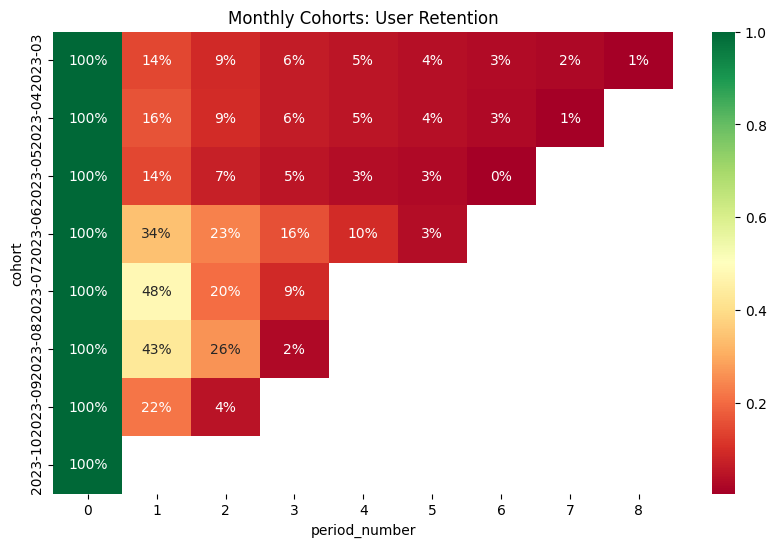

In [46]:
retention_matrix = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='RdYlGn')
plt.title('Monthly Cohorts: User Retention')
plt.show()

In [47]:
!pip install lifelines

from lifelines import KaplanMeierFitter

first_month = df.groupby('uuid')['event_month'].min()
last_month = df.groupby('uuid')['event_month'].max()
duration = (last_month - first_month).apply(attrgetter('n')) + 1

cutoff = df['event_month'].max()
event_observed = (last_month < cutoff).astype(int)

surv_df = pd.DataFrame({
    'uuid': duration.index,
    'duration': duration.values,
    'event': event_observed.values
})


kmf = KaplanMeierFitter()
kmf.fit(durations=surv_df['duration'], event_observed=surv_df['event'])

#Обраховуємо динамічний ARPU по місяцях, щоб не спрощувати дані
active_users_per_month = df.groupby('event_month')['uuid'].nunique()
revenue_per_month = df.groupby('event_month')['revenue_usd'].sum()
arpu_per_month = (revenue_per_month / active_users_per_month).fillna(0)

print("ARPU по місяцях")
print(arpu_per_month)

#Побудова LTV
horizon = 6  # прогноз на 6 місяців
times = np.arange(1, horizon + 1)

#Survival ймовірність для кожного місяця
s_at_t = kmf.survival_function_at_times(times).values

#ARPU для прогнозованих місяців
#якщо horizon більший за наявні дані то треба взяти середнє по відомим місяцям
arpu_horizon = arpu_per_month.iloc[:horizon].reindex(times, fill_value=arpu_per_month.mean())

# Очікуваний дохід
expected_monthly_revenue = arpu_horizon.values * s_at_t
cum_expected_revenue = np.cumsum(expected_monthly_revenue)

ltv_table = pd.DataFrame({
    'month': times,
    'S_t': s_at_t,
    'ARPU_t': arpu_horizon.values,
    'expected_monthly_revenue_per_user': expected_monthly_revenue,
    'cum_expected_revenue_per_user': cum_expected_revenue
})


print("\n=== Kaplan-Meier survival (S(t)) ===")
for t, s in zip(times, s_at_t):
    print(f"S({t}) = {s:.3f}")

print("\n=== LTV build-up by month (per user) ===")
print(ltv_table.to_string(index=False, float_format="%.4f"))

print(f"\nEstimated LTV over {horizon} months (KM + dynamic ARPU) = {cum_expected_revenue[-1]:.2f} USD")

ARPU по місяцях
event_month
2023-03     1.578270
2023-04     3.204351
2023-05     2.933679
2023-06    12.711995
2023-07    16.915231
2023-08    16.450135
2023-09    16.434981
2023-10    15.157090
2023-11    12.832913
Freq: M, dtype: float64

=== Kaplan-Meier survival (S(t)) ===
S(1) = 0.161
S(2) = 0.092
S(3) = 0.062
S(4) = 0.046
S(5) = 0.034
S(6) = 0.019

=== LTV build-up by month (per user) ===
 month    S_t  ARPU_t  expected_monthly_revenue_per_user  cum_expected_revenue_per_user
     1 0.1613 10.9132                             1.7604                         1.7604
     2 0.0922 10.9132                             1.0067                         2.7671
     3 0.0623 10.9132                             0.6798                         3.4469
     4 0.0458 10.9132                             0.4994                         3.9463
     5 0.0338 10.9132                             0.3688                         4.3151
     6 0.0189 10.9132                             0.2058                 

У аналізі я використала мупвайвал метод Kaplan–Meier для оцінки того, як довго користувачі залишаються активними, та поєднала його з динамічним ARPU по місяцях для побудови LTV-прогнозу.
Коротко що я зробила:
Для кожного користувача визначила перший та останній місяць активності, тривалість його життя.
Каплан меєр вміє працювати з цензурованими даними, тобто з користувачами які ще з нами є, і можуть піти в майбутньому, тому я додала ознаку події, чи користувач пішов, чи ще активний.

Як вже згадувалось, замість одного усередненого значення я врахувала помісячну динаміку ARPU, щоб врахувати те, що перші місяці приносять більше.

Далі за формулами розрахована ймовірність виживання кожного місяця, середнфй дохфд на користувача за відомими місяцями. Ці значення перемноживши отримуємо очікуваний дохід на ці місяці. Накопичувальний дохід в кінці дає нам значення прогнозованого LTV на ці місяці - 4,52.

Щоб покращити точність предикту: рахувати survival та ARPU окремо по додаткових ключових ознаках (джерело трафіку, країна, тип підписки). Це не так сильно буде узагальнювати наші дані. Також можна використовувати більш гнучкі сурвайвал моделі.